# Lavaux Sensor Data: Temperature 

In [2]:
import pandas as pd
import os
import glob
import numpy as np
import re
from scipy import stats
import sklearn

from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

# 0. Import Temperature of all files 
readout from HOBO sensors on these dates:
1. 2022-03-08
2. 2023-05-10
3. 2023-09-20

--> First column is temperature, second one RH

In [3]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

### Sensor metadata 

In [4]:
md = pd.read_csv('sensors_metadata.tsv', sep='\t', index_col=0)

# make dict to rename the sensor names with the plot ID 
rename_columns_dict = dict(zip(md["Sensors"], md.index))

### 1. 2021-2022

> note Lavaux_003 measured all 15 min (consider subsampling with `df['Lavaux_003'].resample('1H').mean()`)

> Sensors were installed on 2021-04-20 and read out 2022-03-08 

In [24]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2022 = pd.concat(dfs, axis=1)
df_2022.index = pd.to_datetime(df_2022.index)

# sort by timestamp 
df_2022.sort_index(inplace=True)

# name columns 
df_2022.set_axis(names, axis=1, inplace=True)
df_2022.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2022 = df_2022[(df_2022.index > '2021-04-21 00:30:00') & (df_2022.index < '2022-03-08 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_19181/2671370525.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022.set_axis(names, axis=1, inplace=True)


### 2. 2022-2023 
> note two sensors have gone missing when reading out the sensors in 2023!

In [25]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_1')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023.set_axis(names, axis=1, inplace=True)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_1 = df_2023[(df_2023.index > '2022-03-08 18:00:00') & (df_2023.index < '2023-05-10 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_19181/3571701209.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2023.set_axis(names, axis=1, inplace=True)


### 3. 2023 
growing season of 2023, sensors were collected at harvest (2023-09-20)

In [26]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_2')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023.set_axis(names, axis=1, inplace=True)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_2 = df_2023[(df_2023.index > '2023-05-10 09:00:00') & (df_2023.index < '2023-09-20 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_19181/460153697.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2023.set_axis(names, axis=1, inplace=True)


### 4. Agrometeo Data for Plot 19
downloaded from: https://www.agrometeo.ch/de/meteorologie/data?stations=98&sensors=1%3Aavg,1%3Amin,1%3Amax,1%3Acumsum%3A0,4%3Aavg,4%3Amin,4%3Amax,6%3Asum&from=2021-03-08&to=2023-09-30&scale=hour&groupBy=station&measured=0

In [36]:
agrometeo_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021/Agrometeo_BEL_all.csv', index_col=0)
agrometeo_data.index = pd.to_datetime(agrometeo_data.index)
# Keep only the first column and rename it to 'Plot_18'
agrometeo_data = agrometeo_data.iloc[:, [0]].rename(columns={agrometeo_data.columns[0]: 'Plot_18'})

# set appropriate time frame 
agrometeo_data_time = agrometeo_data[(agrometeo_data.index > '2021-04-21 00:30:00') & (agrometeo_data.index < '2023-09-20 08:00:00')]

### Merge all data

In [37]:
df_temp = pd.concat([df_2022,df_2023_1,df_2023_2, agrometeo_data_time], join='outer', axis=0)
#df_temp.tail()

In [38]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

# to have a look
#df_temp.to_csv('all_data.csv')

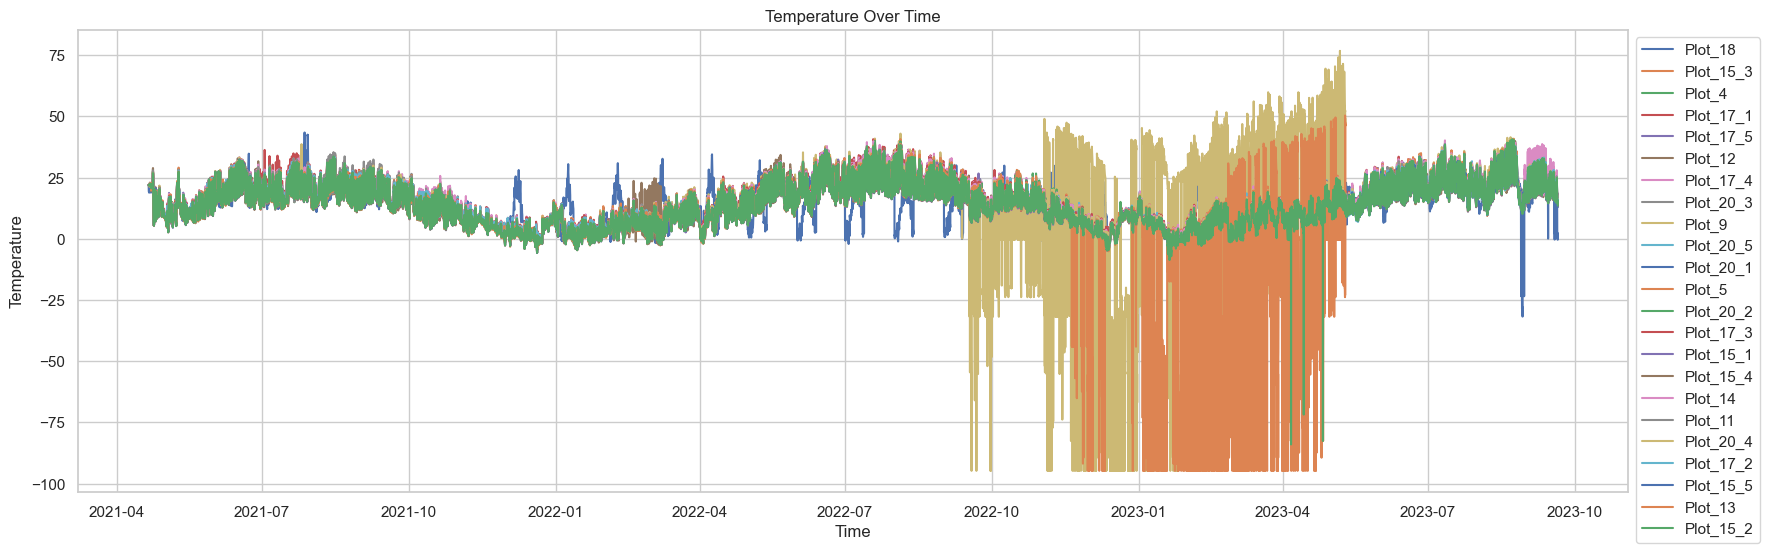

In [39]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

# get mean temperature for each month
show_temps = df_temp.resample('H').mean()

# loop over columns and plot temperatures 
for column in show_temps.columns:
    plt.plot(show_temps.index, show_temps[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

# 1. Outlier correction

### MAD 
Using  median absolute deviation (MAD) to detect outliers (maybe too stringent?). Compare each entry to 5 other entrie at the same timepoint and remove it if it is outside the specified variation.

--> assuming normal distribution the scaling factor is 1.4826 

https://en.wikipedia.org/wiki/Median_absolute_deviation

In [40]:
MAD_threshold = 3.5

MAD_window = 24
MAD_neighbors = 5

In [41]:
# function to compare each value to other values at this timestamp and to remove values outside of the specified threshold 

def remove_outliers(row, num_neighbors = MAD_neighbors, threshold = MAD_threshold):
    # Find non-NaN values in the row
    non_na_indices = row.dropna().index
    
    # If there are fewer than num_neighbors non-NaN values, return the original row
    if len(non_na_indices) < num_neighbors:
        return row
    
    # Extract values for comparison
    values_to_compare = row[non_na_indices].values
    
    # Calculate the median and median absolute deviation (MAD)
    median_value = np.median(values_to_compare)
    mad = np.median(np.abs(values_to_compare - median_value))
    
    # Identify indices of outliers based on the MAD and threshold
    outlier_indices = non_na_indices[np.abs(values_to_compare - median_value) > threshold * mad]
    
    # Replace outliers with NaN
    row[outlier_indices] = pd.NA
    
    return row

In [42]:
# Remove outliers using rolling Median Absolute Deviation (MAD) for each column.

def remove_outliers_rolling(df, window_size = MAD_window, threshold = MAD_threshold):

    result_df = df.copy()

    for column in df.columns:
        column_data = df[column]

        # Use rolling median and rolling MAD
        rolling_median = column_data.rolling(window=window_size, min_periods=1, center=True).median()
        rolling_mad = column_data.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

        # Identify outliers
        outliers = np.abs(column_data - rolling_median) > threshold * rolling_mad

        # Mark outliers in the result DataFrame with NaN
        result_df.loc[outliers, column] = pd.NA

    return result_df

In [43]:
# let's resample per hour 
df = df_temp.resample('H').mean()

# Apply the remove_outliers function to each column in the DataFrame
df_outliers_MAD = df.apply(remove_outliers, axis=1)

# Set window size and apply the function
df_outliers_rollingMAD = remove_outliers_rolling(df)

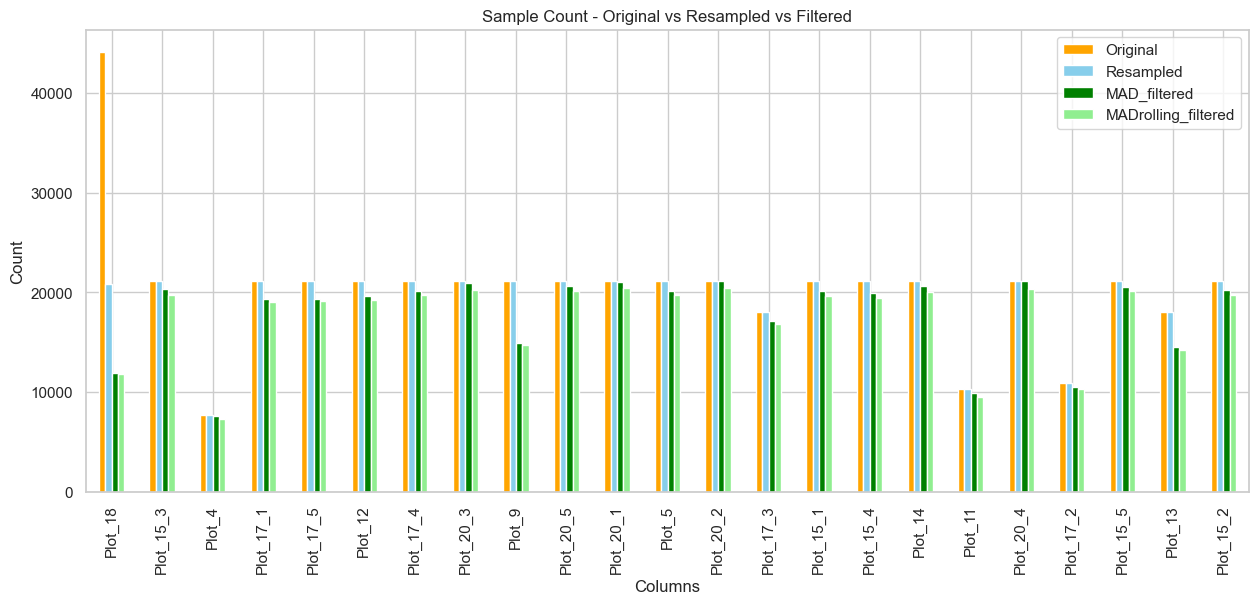

In [44]:
## quickly show how many entries we "loose" from resampling 

original_counts = df_temp.count()
resampled_counts = df_temp.resample('H').mean().count()
MAD_counts = df_outliers_MAD.count()
MADrolling_counts = df_outliers_rollingMAD.count()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Original': original_counts, 'Resampled': resampled_counts, 'MAD_filtered' : MAD_counts, 'MADrolling_filtered' : MADrolling_counts})

# Plot the grouped bar chart
ax = plot_data.plot(kind='bar', figsize=(15, 6), color=['orange','skyblue','green', 'lightgreen'])

# Set plot labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Columns')
ax.set_title('Sample Count - Original vs Resampled vs Filtered')

# Display legend
ax.legend()

# Show the plot
plt.show()


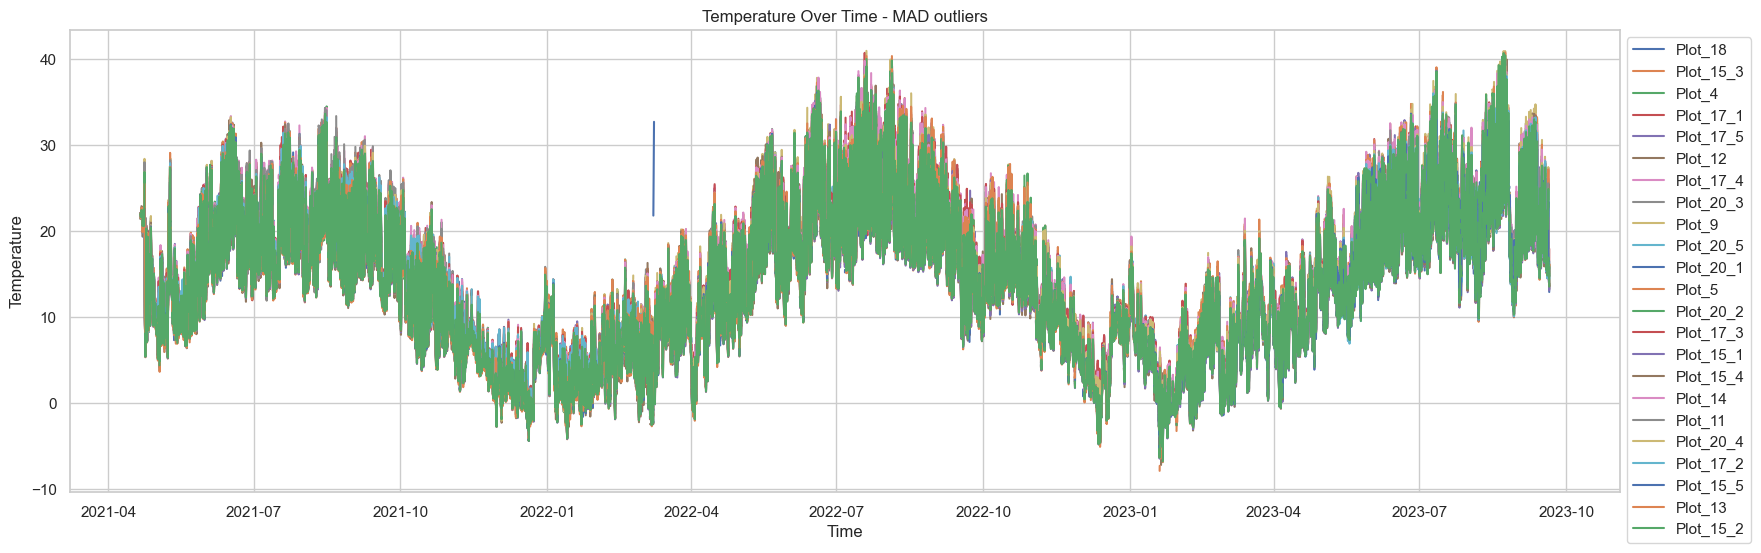

In [45]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_MAD.columns:
    plt.plot(df_outliers_MAD.index, df_outliers_MAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD outliers')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

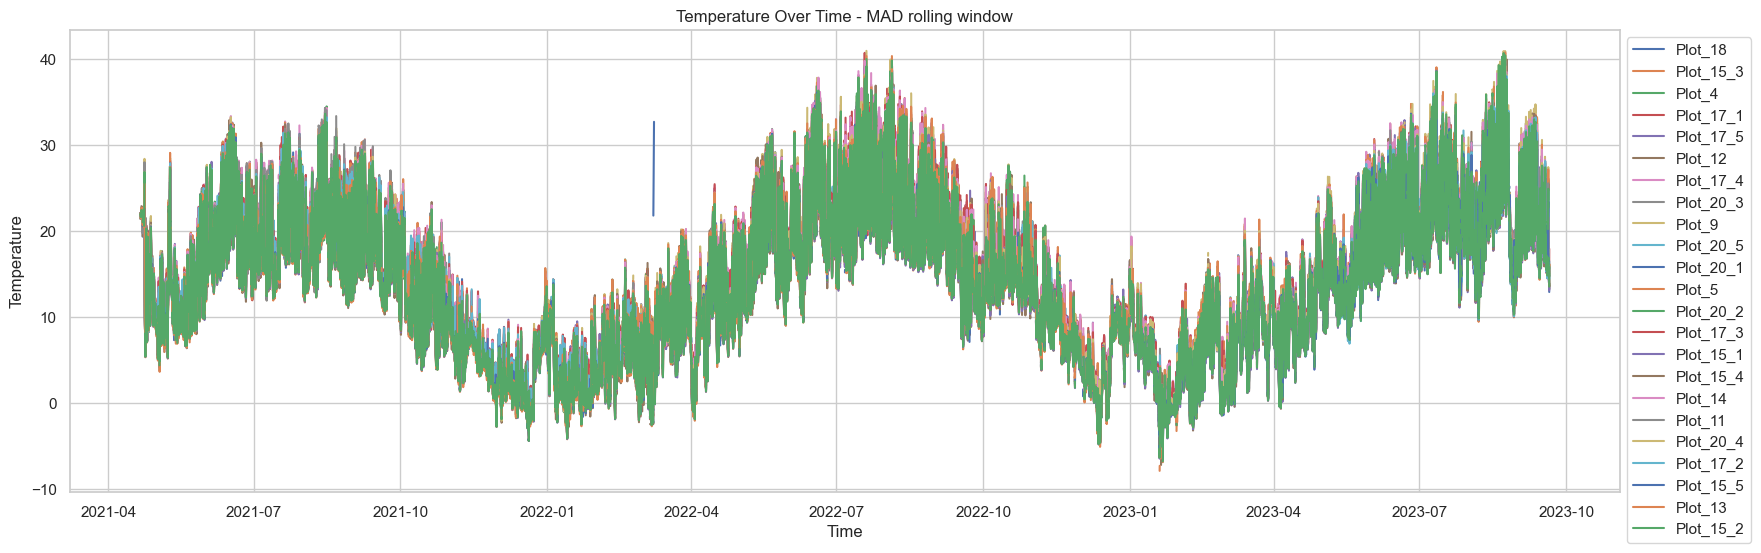

In [46]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_rollingMAD.columns:
    plt.plot(df_outliers_rollingMAD.index, df_outliers_rollingMAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD rolling window')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

# 2. Comparing the years 

--> 2021 was substantially colder and 2022 particularly hot 

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_19181/3618824068.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")


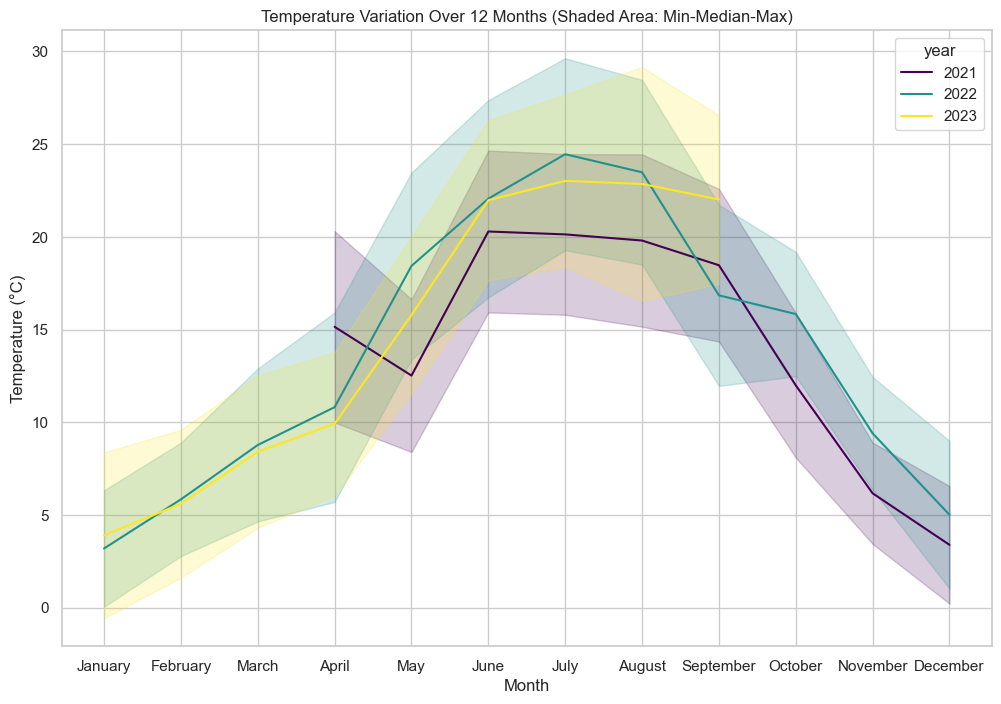

In [47]:
df = df_outliers_MAD.copy()

# Extract year and month from the timestamp
df['year'] = df.index.year
df['month'] = df.index.month
df_melted = pd.melt(df, id_vars=['year', 'month'], var_name='temperature_type', value_name='temperature')

# Create a line plot with shaded area using seaborn
plt.figure(figsize=(12, 8))

sns.set_style("whitegrid")

sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
plt.title('Temperature Variation Over 12 Months (Shaded Area: Min-Median-Max)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

# Customize x-axis ticks for every month
plt.xticks(range(1, 13), [pd.to_datetime(str(i), format='%m').strftime('%B') for i in range(1, 13)])

plt.show()

# 3. Interplot variance

### Statistical testing 

> mean temperatures of months / weeks **are not** statistically significant between each other 

In [19]:
df = df_outliers_MAD

In [20]:
# Perform Kruskal-Wallis test on each row
p_values = []
for _, row in df.iterrows():
    _, p_value = stats.kruskal(*row.values)
    p_values.append(p_value)

# Create a new DataFrame with p-values
p_value_df = pd.DataFrame({'P-Value': p_values}, index=df.index)

# Filter and print rows with significant p-values
significant_rows = p_value_df[p_value_df['P-Value'] < 0.05]
print(significant_rows)

Empty DataFrame
Columns: [P-Value]
Index: []


### Add some metadata

In [21]:
# Merge the dataframes based on the sensor name (reset the index first) and sort: first by altitude and then by plot 
ave_temp_new = df_outliers_MAD.reset_index() 
md_renamed = md.reset_index()
merged_df = ave_temp_new.melt(id_vars='index', var_name='ID', value_name='Temperature').merge(md, on='ID').sort_values(by = ['Altitude', 'ID'])

### Boxplots

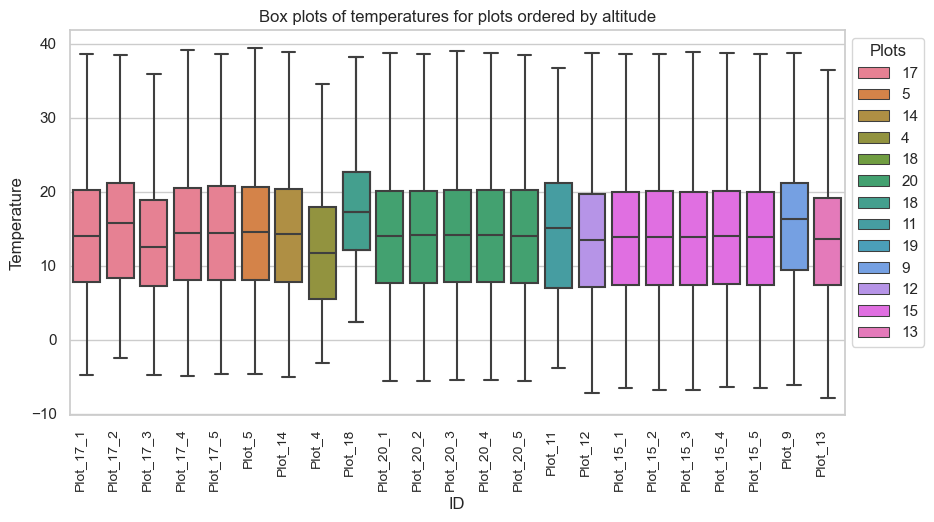

In [23]:
plt.figure(figsize=(10,5))

plots_ordered_by_altitude = [17, 5, 14, 4, 18, 20, 18, 11, 19, 9, 12, 15, 13]

ax = sns.boxplot(x='ID', y='Temperature', hue="Plots", 
                 width=0.8, dodge=False,
                 data=merged_df, palette="husl", 
                 hue_order=plots_ordered_by_altitude,
                 showfliers = False
                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Box plots of temperatures for plots ordered by altitude')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
)
None
# the None is to not show the lables as output 

### Heatmaps

In [48]:
df = df_outliers_MAD.copy()

# Extract unique plot names
plot_names = set('_'.join(col.split('_')[:2]) for col in df.columns)
plot_names

# Calculate median for each group of columns with the same plot name
median_values = {}
for plot_name in plot_names:
    columns = [col for col in df.columns if plot_name in col]
    median_values[plot_name] = df[columns].median(axis=1)

# Concatenate median values into a new DataFrame
df_median = pd.DataFrame(median_values)

In [49]:
# Create heatmap
df_heatmap = df_median.T

# Get month names
monthly = df_median.resample('M').mean()
month_names = monthly.index.strftime('%B, %Y')

# Heatmap 
plt.figure(figsize=(20, 5), dpi=1000)
heatmap = sns.heatmap(data=df_heatmap, cmap='coolwarm', annot=None, 
                      cbar_kws={'label': 'Temperature [°C]', 'shrink': 0.7, 'aspect': 15, 'pad': 0.02})
#plt.title('Heatmap of all plots over the years')

# Set custom x-axis labels
n = len(month_names)
heatmap.set_xticks(np.linspace(0, n - 1, n))
heatmap.set_xticklabels(month_names)

# Calculate positions for the labels
width = heatmap.get_xlim()[1] - heatmap.get_xlim()[0]
positions = np.linspace(heatmap.get_xlim()[0], heatmap.get_xlim()[1], len(month_names))

# Set label positions
plt.xticks(positions, month_names)

plt.tight_layout()
plt.show()

### WIP: Compare the night and day temperatures

In [ ]:
# Define the start and end times for day and night
day_start_time = pd.to_datetime('6:00:00').time()
day_end_time = pd.to_datetime('18:00:00').time()

# Extract the day and night temperatures using conditional indexing
day_temperatures = df_outliers_removed[df_outliers_removed.index.time >= day_start_time].resample('D').mean()
night_temperatures = df_outliers_removed[df_outliers_removed.index.time < day_start_time].resample('D').mean()

# 4. Intraplot variance

Plots 15, 17 and 20 have 5 sensors each and we can test whether the mean temperature per month is statistically significant between those sensors. 

> does not look like it

In [ ]:
# Get a list of sensors at a specific plot and subset the datafame to only contain data from these plots 
plot_of_interest = 17

selected_plots = md.loc[md['Plots'] == plot_of_interest].index.to_list()
df_subset = df_outliers_removed[selected_plots]

# get mean temperature for each month (dropNA to do a significance test)
average_temps_subset = df_subset.resample('D').mean() #.dropna()

In [ ]:
average_temps_subset.head(30)

In [ ]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

for column in average_temps_subset.columns:
    plt.plot(average_temps_subset.index, average_temps_subset[column], label=column)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
average_temps_subset.boxplot()

plt.xticks(rotation=90)
plt.xlabel('Sensor')
plt.ylabel('Average Monthly Temperatures')
title = 'Average Temperatures of the Sensors in Plot ' + str(plot_of_interest)
plt.title(title)

plt.show()


In [ ]:
# compare min and max temperatures 
daily_max = df_subset.resample('D').max().dropna()
daily_min = df_subset.resample('D').min().dropna()

# two plots next to each other 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the first box plot on the first axes
daily_max.boxplot(ax=axs[0])

# Create the second box plot on the second axes
daily_min.boxplot(ax=axs[1])

# Set the title for each plot
axs[0].set_title('Max Temp')
axs[1].set_title('Min Temp')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# 5. WIP: Growing Degree Days 

In [29]:
# get the median temperatures of each day per year
df_median_21 = df_outliers_MAD[(df_outliers_MAD.index > '2021-01-01') & (df_outliers_MAD.index < '2021-12-31')].resample('D').median()
df_median_22 = df_outliers_MAD[(df_outliers_MAD.index > '2022-01-01') & (df_outliers_MAD.index < '2022-12-31')].resample('D').median()
df_median_23 = df_outliers_MAD[(df_outliers_MAD.index > '2023-01-01') & (df_outliers_MAD.index < '2023-12-31')].resample('D').median()

In [30]:
def calculate_total_gdd(dataframes, base_temperature=10.0):
    """
    Calculate the total Growing Degree Days (GDD) for each DataFrame in the input list.

    Parameters:
    - dataframes: List of DataFrames with temperature data (rows: days, columns: temperature measurements).
    - base_temperature: Base temperature for GDD calculation.

    Returns:
    - DataFrame with total GDD for each input DataFrame, columns named after the input DataFrames.
    """
    result_dict = {}

    for i, df in enumerate(dataframes):
        # Calculate temperature differences
        temperature_differences = df - base_temperature
        temperature_differences[temperature_differences < 0] = 0

        # Calculate cumulative sum to get Growing Degree Days
        gdd_data = temperature_differences.cumsum()

        # Sum GDD for each column to get total GDD per column
        total_gdd_per_column = gdd_data.sum()

        # Store the total GDD in the result dictionary with the DataFrame name
        result_dict[f'GDD_202{i + 1}'] = total_gdd_per_column

    # Create a new DataFrame from the result dictionary
    result_df = pd.DataFrame(result_dict)

    return result_df

In [31]:
# Apply the function to each column in the DataFrame
GDD_all = calculate_total_gdd([df_median_21, df_median_22, df_median_23])
GDD_all

,GDD_2021,GDD_2022,GDD_2023
Plot_18,216327.099525,142606.4000,154263.66525
Plot_15_3,200454.366000,306557.6345,105791.21300
Plot_4,208682.905000,11.8400,0.00000
Plot_17_1,208988.602500,309733.2755,108763.37350
Plot_17_5,217091.407000,321287.8215,111963.35950
Plot_12,198612.388500,314703.2695,109887.94500
Plot_17_4,215178.597000,310049.2050,110107.34350
Plot_20_3,208747.126000,320276.5815,111520.43850
Plot_9,203197.156000,216398.4695,101378.76750
Plot_20_5,213510.647500,326616.1435,112456.24800


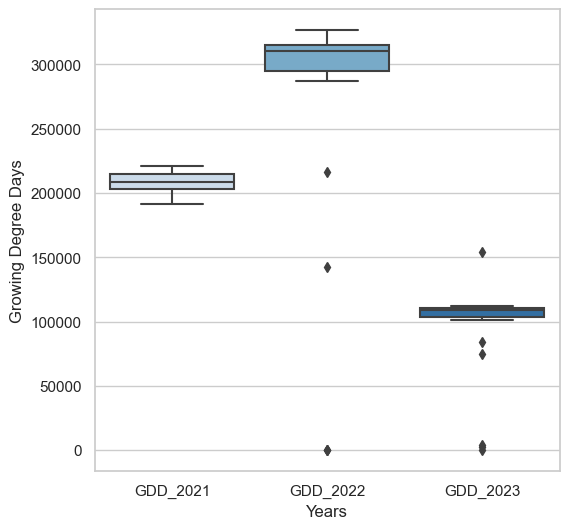

In [32]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a boxplot with Seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(data=GDD_all, showfliers=True, palette='Blues')  # Set showfliers to True if you want to include outliers

# Set plot labels and title
plt.xlabel('Years')
plt.ylabel('Growing Degree Days')
plt.title('')

# Show the plot
plt.show()

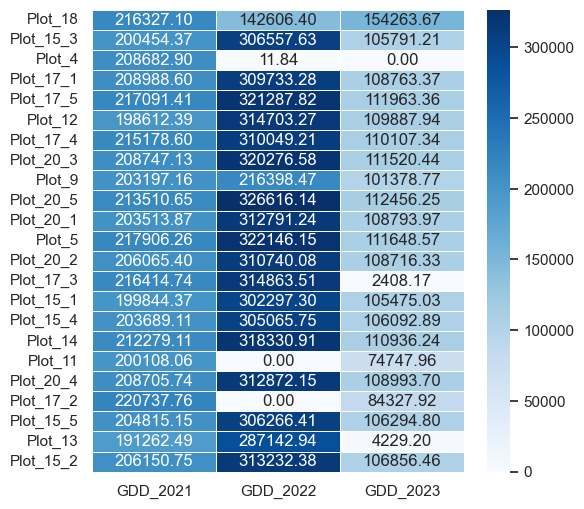

In [33]:
# Heatmap 
plt.figure(figsize=(6, 6))
sns.heatmap(GDD_all, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)

# Show the plot
plt.show()

## Temperature differences of specific months

### Let's check out Temperatures in August! 

In [ ]:
## compare temperature in August ?
df_Aug21 = df_temp[(df_temp.index > '2021-08-01 00:30:00') & (df_temp.index < '2021-08-31 23:00:00')]
df_Aug21.describe()

In [ ]:
df_Aug22 = df_temp[(df_temp.index > '2022-08-01 00:30:00') & (df_temp.index < '2022-08-31 23:00:00')]
df_Aug22.describe()

In [ ]:
meds = df_Aug21.median()
meds.sort_values(ascending=False, inplace=True)
df_Aug = df_Aug[meds.index]
df_Aug.boxplot()

plt.xticks(rotation=90)

plt.show()


## WIP: Check out patterns in time 

In [ ]:
df['hour'] = df.index.hour
df['month'] = df.index.month
df['yearday'] = df.index.dayofyear

In [ ]:
hourly_sst = df.Lavaux_001.groupby(df.hour).mean()
hourly_sst.plot();

# DEL: Unsupervised Clustering

-> https://towardsdatascience.com/hands-on-climate-time-series-clustering-using-machine-learning-with-python-6a12ce1607f9

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [ ]:
# data preprocessing: get hourly mean and drop rows with NA 
df_temp_cluster = df_temp.resample('H').mean()
A = df_temp_cluster.shape[0]
df_temp_cluster = df_temp_cluster.dropna(axis=0) # drop rows with NA 
B = df_temp_cluster.shape[0]

# transpose 
data_array = np.array(df_temp_cluster.T.values)

print('Number of rows with NA dropped: ', A-B)


In [ ]:
model = TimeSeriesKMeans(n_clusters=9, metric="dtw", max_iter=10)
model.fit(data_array)
plots_list = df_temp_cluster.T.index.tolist()

In [ ]:
# apply the modell
y = model.predict(data_array)

# define our time step array
x = df_temp_cluster.index

In [ ]:
k_dict = dict(zip(plots_list, clusters))
k_dict

In [ ]:
# Plotting
plt.figure(figsize=(20,20))
colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('City=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

In [ ]:
plt.figure(figsize=(20,60))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
 7, 0, 5, 1, 1, 8, 1, 7, 4, 7, 3, 1, 4, 1, 0, 0, 5, 6, 2, 1, 0, 0,
       0

colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,23):
    plt.subplot(3,8,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.hist(data_array[k],color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('Class = %s'%(Names[j-1]),fontsize=20)
    plt.xlim(data_array.min(),data_array.max())

==> DELETE THIS PART

In [ ]:
df_temp_cluster = df_temp.resample('H').mean().dropna(axis=0)

df_temp_cluster

In [ ]:
# Initialize the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=10)

# Fit the model to the dataframe
kmeans.fit(df_temp_cluster.values)
clusters = kmeans.fit_predict(df_temp_cluster.transpose())
#kmeans.predict(df_temp_cluster)

# Get the cluster labels for each data point
#labels = kmeans.labels_

# Get the centroids of the clusters
#centroids = kmeans.cluster_centers_


# Add the cluster labels as a new column in the dataframe
#df_temp_cluster['Cluster'] = labels

In [ ]:
plt.scatter(df_temp_cluster.columns, df_temp_cluster.index, c=clusters)
plt.xlabel('Location')
plt.ylabel('Timestamp')
plt.title('K-means Clustering')
plt.xticks(rotation=90)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1, projection='3d')


# Plot the data points with cluster labels
for i, label in enumerate(labels):
    ax.scatter(df_temp_cluster.index[i], df_temp_cluster.columns, df_temp_cluster.iloc[i, :], c=label, cmap='viridis')

# Plot the centroids
#for centroid in centroids:
#    ax.scatter(df_temp_cluster.index[0], df_temp_cluster.columns, centroid, c='black', marker='X')

# Set labels and title
#ax.set_xlabel('Timestamp')
#ax.set_ylabel('Location')
#ax.set_zlabel('Value')
#ax.set_title('K-means Clustering of Data')

# Show the plot
plt.show()

# Average temperature per plot and year

In [24]:
# df_median is created above and the median of the multiple sensors in the same plot
mean_temp_years = df_median.resample('Y').mean()
mean_temp_years

,Plot_9,Plot_14,Plot_18,Plot_15,Plot_4,Plot_13,Plot_12,Plot_5,Plot_20,Plot_11,Plot_17
2021-12-31,13.830994,14.410127,15.987177,13.940197,14.154357,13.583831,13.582716,14.626479,14.119217,13.843229,14.706146
2022-12-31,14.981817,14.023768,NaN,13.490598,4.559400,13.462904,13.388782,14.157781,13.836491,4.295760,14.191335
2023-12-31,20.823268,14.657068,24.898686,14.380918,NaN,11.078642,14.292481,15.019880,14.637046,22.695666,14.904972
